# Transforms

> Various Transforms to be piped to create a DataLoader

In [2]:
#| default_exp data.transforms

In [3]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

%load_ext autoreload
%autoreload 2

In [4]:
#| export
from __future__ import annotations
from math import sqrt, ceil

from fastai.vision.all import *
from fastai.data.all import *
from fastcore.basics import patch
from pathlib import Path
import pandas as pd
import torchvision.transforms as T

from scipy.signal import savgol_filter
from tqdm import tqdm

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configs

In [ ]:
root_dir = Path('../../_data/')

## Utilities

In [51]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [52]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

In [53]:
def get_dls(paths, analytes=['725'], bs=32, seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=RandomSplitter(valid_pct=0.2, seed=seed),
                       item_tfms=[AvgTfm()],
                       batch_tfms=[SNVTfm(),
                                   LogTfm])
    return dblock.dataloaders(paths, bs=bs, num_workers=6)

## Input (spectra)

In [5]:
#|eval: false
path = Path('../_data/kssl-mirs-v2')
#path = Path('../_data/lucas-nirs')

In [6]:
#|eval: false
path.ls()

(#46305) [Path('../_data/kssl-mirs-v2/180338'),Path('../_data/kssl-mirs-v2/172221'),Path('../_data/kssl-mirs-v2/177753'),Path('../_data/kssl-mirs-v2/184798'),Path('../_data/kssl-mirs-v2/53759'),Path('../_data/kssl-mirs-v2/74947'),Path('../_data/kssl-mirs-v2/176681'),Path('../_data/kssl-mirs-v2/1855'),Path('../_data/kssl-mirs-v2/175004'),Path('../_data/kssl-mirs-v2/34499')...]

In [7]:
#| export
class Spectra(Tensor):
    "A 'showable' spectra class subclassing torch.Tensor"
    domain = domain_name = light = None
        
    def show(self, ctx=None, wn=np.arange(4000, 600, -2), figsize=(8,2), **kwargs):
        spectra = self
        if ctx is None: _,ctx = plt.subplots(figsize=figsize)
        
        if Spectra.domain_name == 'wavenumber':
            ctx.set_xlim(np.max(Spectra.domain), np.min(Spectra.domain))

        ctx.set(xlabel=Spectra.domain_name.capitalize() + ' →', 
                ylabel=Spectra.light.capitalize())
        
        ctx.set_xlabel(Spectra.domain_name.capitalize() + '→', loc='right')
        ctx.set_ylabel(Spectra.light.capitalize() + ' →', loc='top')
        
        ctx.set_axisbelow(True)
        for spectrum in spectra:
            _ = ctx.plot(Spectra.domain, spectrum, c='steelblue', lw=1)
        ctx.grid(True, which='both')
        return ctx
    
    @classmethod
    def reset(cls):
        cls.domain = cls.domain_name = cls.light = None

In [8]:
#| export
class SpectraTfm(Transform):
    "Transform folder path into a torch array of dimension: (n_replicates, n_wavenumbers)"        
    def __init__(self):
        Spectra.reset()
    
    def encodes(self, 
                o:L # list of spectrum replicates
               ):
        n, m  = len(pd.read_csv(o[0])), len(o)
        x = np.empty((m,n))
        for i, fname in enumerate(o):
            df = pd.read_csv(fname)
            if Spectra.light is None:
                Spectra.domain_name, Spectra.light = df.columns
                Spectra.domain = df[Spectra.domain_name].values
            x[i,:] = df[Spectra.light].values
        return Spectra(torch.Tensor(x)) 

In [9]:
#|eval: false
get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d', fname.name))
SpectraTfm()(get_spectra(path.ls()[0]))

Spectra([[0.1680, 0.1682, 0.1684,  ..., 1.4982, 1.4934, 1.4900],
         [0.1742, 0.1744, 0.1745,  ..., 1.5319, 1.5263, 1.5216],
         [0.1706, 0.1708, 0.1710,  ..., 1.5089, 1.5031, 1.4992],
         [0.2243, 0.2245, 0.2248,  ..., 1.5664, 1.5592, 1.5532]])

In [10]:
#| export
def SpectraBlock():
    return TransformBlock(type_tfms=SpectraTfm())

### Item transforms

In [9]:
#| export
class ToAbsorbanceTfm(Transform):
    "Transform spectra replicates taking their average"
    def encodes(self, x:Spectra):
        return torch.log10(x)

In [11]:
#| export
class RandWAvgTfm(Transform):
    "Transform spectra replicates taking their random weighted averages for data augmentation"
    def encodes(self, x:Spectra):
        n = len(x)
        return torch.matmul(self._weights(n), x)  
    def _weights(self, n):
        weights = torch.rand(n)
        return (weights/weights.sum()).unsqueeze(dim=0)

In [125]:
#| export
class AvgTfm(Transform):
    "Transform spectra replicates taking their average"
    def encodes(self, x:Spectra):
        return torch.mean(x, dim=0, keepdim=True)

In [16]:
#| export
class DerivTfm(Transform):
    def __init__(self, window_length=11, polyorder=1, deriv=1):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv
        
    def encodes(self, 
                x:Spectra
               ):
        x = savgol_filter(x.detach().numpy(), 
                          self.window_length, self.polyorder, self.deriv)
        return Spectra(torch.Tensor(x))

In [14]:
#| export
class NormalizeTfm(Transform):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def encodes(self, x:Spectra):
        return (x - self.mean)/self.std

In [15]:
#| export
# TBR
class TrimTfm(Transform):
    def encodes(self, 
                x:Spectra
               ):
        val = x[:,1675]
        x[:,1675:] = val
        return x

### Batch transforms

In [48]:
#| export
class SNVTfm(Transform):
    "Standard Normal Variate Transform of input spectrum"
    def encodes(self, x:Spectra):
        mean, std = torch.mean(x, dim=2, keepdim=True), torch.std(x, dim=2, keepdim=True)
        return (x - mean)/std

In [41]:
#| export
class GADFTfm(Transform): 
    """
    Transform batch of spectra S (B, 1, len(S)) into their Grammian Difference Matrix Field (GADF) of shape (B, 1, H, W)
    
    Notes:
    https://arxiv.org/pdf/1506.00327.pdf
    """
    def __init__(self, neg=True):
        self.neg = neg
        
    def rescale(self, x):
        m = torch.min(x, dim=-1, keepdim=True).values
        M = torch.max(x, dim=-1, keepdim=True).values
        return ((x - M) + (x - m)) / (M - m) if self.neg else (x - m) / (M - m)

    def encodes(self, 
                x:Spectra # Batch of spectra S: (B, 1, len(S))
               ): 
        X, I = self.rescale(x), torch.ones_like(x)
        K = torch.sqrt(I - torch.square(X))
        return (torch.matmul(torch.transpose(K, 1, 2), X) - 
                torch.matmul(torch.transpose(X, 1, 2), K)).unsqueeze_(1)

In [ ]:
#| export
class ResizeTfm(Transform):
    def __init__(self, size=256):
        self.size = size
        
    def encodes(self, 
                x:Spectra
               ):
        return T.Resize(self.size)(x)

In [ ]:
#| export
class To3DTfm(Transform):
    def __init__(self, n):
        n_channel = n // 3
        self.edge_side = ceil(sqrt(n_channel))
        self.padding = 3*self.edge_side**2 - n - 1
        
    def encodes(self, 
                x:Spectra
               ):
        x = F.pad(x, (1, self.padding), mode='constant')
        return x.view(3, self.edge_side, self.edge_side)

In [50]:
#|eval: false
tfms = Pipeline([SpectraTfm, AvgTfm, To3DTfm(1700)])
tfms(get_spectra(path.ls()[0]))

In [ ]:
#|eval: false
tfms = Pipeline([SpectraTfm, AvgTfm, DerivTfm, SNVTfm])
tfms(get_spectra(path.ls()[0]))

Spectra([[-0.1044, -0.1044, -0.1044,  ..., -0.8187, -0.8187, -0.8187]])

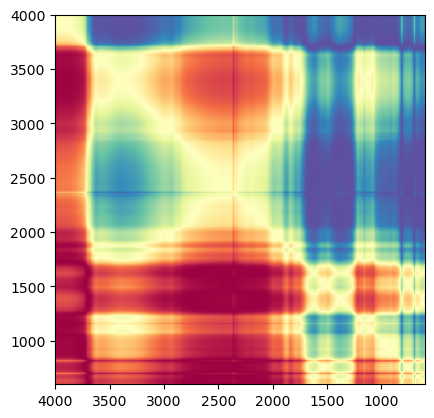

In [ ]:
#|eval: false
tfms = Pipeline([SpectraTfm, GADFTfm])
plt.imshow(tfms(get_spectra(path.ls()[0])), cmap='Spectral', origin='upper', extent=[4000,600,600,4000]);

In [ ]:
#| export
class RandomCropTfm(Transform):
    def __init__(self, size=256):
        self.size = size
        
    def encodes(self, 
                x:Spectra
               ):
        return T.Resize(self.size)(x.unsqueeze(0))

In [ ]:
#class CHWTfm(Transform):
#    def __init__(self, n_channel=3):
#        self.c = n_channel
#    
#    def encodes(self, 
#                x:Spectra
#               ):
#        x = torch.flatten(x)
#        n = len(x) 
#        n_chunk = n // self.c
#        s = round(np.sqrt(n_chunk)) # H=W=s
#        return x[:(self.c*s**2)].view((self.c, s, s))

## Target (Soil properties)

In [ ]:
#| export
class Analytes(Tensor, ShowTitle):
    def __init__(self, ys):
        self.ys = ys
        # Ideally, w'd like to show (idx: 1234 | 725: 0.123 | 433: 0.7) decoded

In [ ]:
#| export   
class AnalytesTfm(Transform):
    "Transform a folder path into a tensor of soil analyte(s) measurement"
    def __init__(self, 
                 analytes:list|None=None):
        self.analytes = analytes
        
    def encodes(self,
                o:Path # Path to directory containing both spectra and analyte(s) measurement
               ):
        df = pd.read_csv(o, dtype={'analyte': str, 'value': float})
        if self.analytes:
            df = df[df.analyte.isin(self.analytes)]
        return Analytes(df['value'].values)

In [ ]:
#|eval: false

# To select only positive values
# t = AnalytesTfm(analytes=['725'])
#%time paths = [p for p in tqdm(path.ls()) if t(p) > 0]

In [ ]:
#| export
def AnalytesBlock(analytes):
    return TransformBlock(type_tfms=AnalytesTfm(analytes))

In [ ]:
#| export
class LogTfm(Transform):
    def encodes(self, ys:Analytes):
        return torch.log10(ys)

## How to use these transforms?

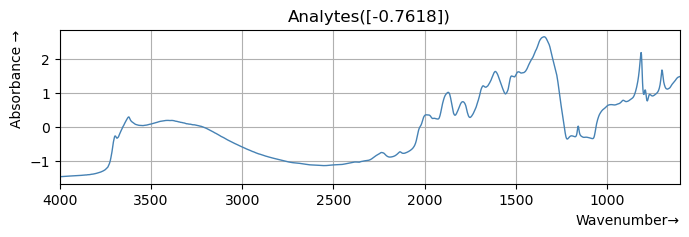

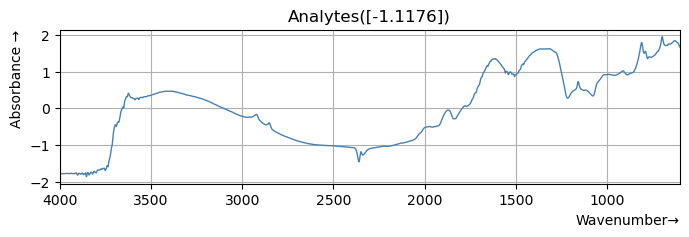

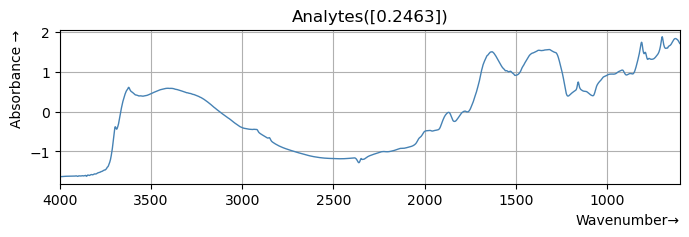

In [ ]:
#|eval: false
get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d', fname.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[725])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), SNVTfm(), 
                              LogTfm()])

dls = dblock.dataloaders(path.ls(), bs=3)
dls.show_batch()

In [ ]:
#|eval: false
get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d', fname.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[725])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), SNVTfm(), GADFTfm(), Resize(256),
                              LogTfm()])

dls = dblock.dataloaders(path.ls(), bs=3)
#dls.show_batch()

In [ ]:
dls.one_batch()[0].shape

torch.Size([3, 1700, 1700])

## Tabular

In [ ]:
#| export
def asTabular(dls):
    "Stack torch dataloader batches as numpy array"
    xs, ys = [], []
    for x, y in tqdm(dls):
        xs.append(x)
        ys.append(y)
    return (torch.cat(ds).squeeze().numpy() for ds in (xs, ys))